# LangGraph + CRAG

CRAG stands for corrective RAG.

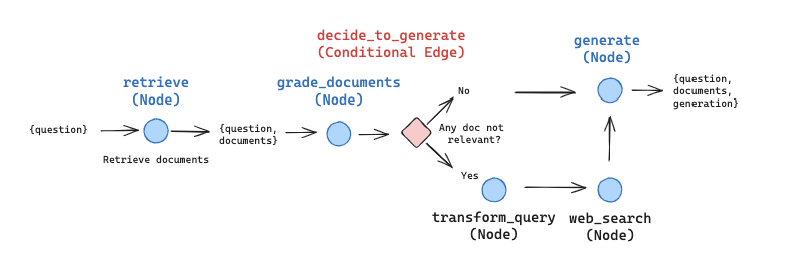

Workflow:</br>

    when a user make a prompt</br>
    
    
    1. It will goes to a Retriver, Retriver return relevant documents</br>
    2. Grade node will check the relevance of retrieved documents</br>
    3. If the retrived ones are relevant, It will route for generation of the final answer</br>
    4. else, it will re-write the query & so do the web search(external source)</br>
    

In [1]:
OPENAI_API_KEY="sk-"

## Define state object

In [2]:
from typing import Dict, TypedDict

class Graph_state(TypedDict):
    """at each node, the Graph_state got updated. this object is pass between nodes"""
    key: Dict[str, any]

### Set a document Retriever

we need a retriver that returns the relevant documents based on user question.

In [3]:
import json
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import DocArrayInMemorySearch
from langchain_openai import OpenAIEmbeddings

In [4]:
# read json doc
with open ('data.txt') as f:
    data=json.load(f)
    

# Extract text from the JSON data
text=""
for category, items in data.items():
    for item in items:
        text += f"{item['name']}. {item['description']}{item['price']}.{item['ingredients']}.{item['options']}.{item['availability']}. "

# split the text documents to chunks & generate the vector embeddings

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,
    chunk_overlap=20,
    length_function=len,
    is_separator_regex=False,
)

chunks = text_splitter.create_documents([text])

embeddings = OpenAIEmbeddings(api_key=OPENAI_API_KEY)

db = DocArrayInMemorySearch.from_documents(chunks, embeddings)

In [5]:
retriever=db.as_retriever()

## Define Nodes 

1. Retrieve</br>
2. Grade</br>
3. Generate</br>
4. re_write_query</br>
5. web_search</br>

**1.Retrieve**

we need to call a retriver to retrieve relevant documents to the user query & return them to the caller.

In [6]:
# retrieve node function

def retrieve(state):
    print("n-----Retrieving documents-----\n")
    question=state['key']['question']
    relevant_docs=retriever.get_relevant_documents(question)
    print(question)
    return {'key':{'question':question,'documents':relevant_docs}}

**2.Grade**

Grade node will check teh relevance of retrieved documents. so we need a LLm chain to check whether the retrived documents as relevant or not. we need a pydantic parser to ensure that the the output of the grade node should be either 'yes' or 'no'.

It will filter the context

In [7]:
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain.output_parsers import PydanticOutputParser,PydanticToolsParser
from langchain_core.utils.function_calling import convert_to_openai_tool

In [8]:
def grade(state):
    
    print("n-----Check the relevance of documents retrieved-----\n")
    
    question=state['key']['question']
    documents=state['key']['documents']
    
    print(question)
    
    class binary_output(BaseModel):
        binary_response: str =Field(description="return either 'yes' or 'no'")
    
    parser = PydanticToolsParser(tools=[binary_output])
    
    prompt=PromptTemplate(template="""
    You are a document Grader. you will check the relevance of context to the {question}.
    you will check the context {context} contains the keywords in question or not.
    
    based on your check, you will return 'yes' if the context is relevant, else you will return a 'no'.
    """,
    input_variables=["question", "context"])
    
    model = ChatOpenAI(temperature=0, model="gpt-4-0125-preview",api_key=OPENAI_API_KEY)
    
    # convert tool into openai_function & bind the tools with model
    
    grade_tool_oai = convert_to_openai_tool(binary_output)
    
    
    llm_with_tool = model.bind(
        tools=[convert_to_openai_tool(grade_tool_oai)],
        tool_choice={"type": "function", "function": {"name": "binary_output"}},
    )
    
    relevance_chain = prompt| llm_with_tool| parser

    
    filtered_docs=[]
    search='No'
    
    for d in documents:
        score = relevance_chain.invoke({"question": question, "context": d.page_content})
        grade = score[0].binary_response
        if grade == "yes":
            print("---GRADE: Relevant document---")
            filtered_docs.append(d)
        else:
            print("---GRADE: Irrelevant document---")
            search = "Yes"
            continue

    
    return   {"key":{'question':question, 'documents':filtered_docs,"do_web_search": search}}

**3.Generate**

In [9]:
# we need to generate a response to user query based on the context
# so we need LLM chain to generate response

In [10]:
from langchain.prompts.prompt import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI
from operator import itemgetter

In [11]:
# we need to generate a response to user query based on the context

def generate(state):
    print("n-----Generating Response-----\n")
    question=state['key']['question']
    context=state['key']['documents']
    
    prompt=PromptTemplate(template="""
    Generate response to user query {question} based on context {context}
    """,
    input_variables=["question", "context"])
    
    model = ChatOpenAI(temperature=0, model="gpt-4-0125-preview",api_key=OPENAI_API_KEY)
    
    
    rag_chain = prompt| model| StrOutputParser()
    
    response=rag_chain.invoke({"question":question,"context":context})
    
    print(question)
    
    return {'key':{'question':question,'documents':context, 'generation':response}}

**4. re_write_query**

In [12]:
# so we need a LLM chain to re write the query

In [13]:
def re_write_query(state):
    print("n-----Transforming the query-----\n")
    
    question=state['key']['question']
    
    model = ChatOpenAI(temperature=0, model="gpt-4-0125-preview",api_key=OPENAI_API_KEY,streaming=True)

    prompt=PromptTemplate(template="""
    re write {question} that is compatible to do the web search. return transformed query to user.
    """,
    input_variables=["question"])
    transform_chain = prompt| model| StrOutputParser()

    trasformed_query=transform_chain.invoke({'question':question})

    return {'key':{'question': trasformed_query}}
    

**5. Do_web_seach**

In [14]:
# if the do_web_search parameter is true, then do the websearch.

In [15]:
from langchain.chains import LLMChain
from openai import OpenAI

In [16]:
def web_search(state):
    print("n-----Do the search-----\n")
    question=state['key']['question']
    client = OpenAI(api_key=OPENAI_API_KEY)
    completion = client.chat.completions.create(
    model="gpt-3.5-turbo",
    messages=[
    {"role": "system", "content": "You are a web search assistant, you are able to answer any question to user."},
    {"role": "user", "content": question}
    ]
    )
    
    return {"key":{'question':question, 'documents':completion.choices[0].message}}

# Define Helper function (after grade node)

In [17]:
def check_relevance(state):
    search=state['key']['do_web_search']
    documents=state['key']['documents']
    print(search)
    if search=="Yes" and documents==[]:
        print("---DECISION: TRANSFORM QUERY and RUN WEB SEARCH---")
        return "re_write_query"
    else:
        return "generate"
    

# Define Graph

In [18]:
from langgraph.graph import StateGraph, END
# Define a new graph
workflow = StateGraph(Graph_state)

# add nodes
workflow.add_node("retrieve",retrieve)
workflow.add_node("generate",generate)
workflow.add_node("re_write_query",re_write_query)
workflow.add_node("web_search",web_search)
workflow.add_node("grade",grade)

workflow.set_entry_point("retrieve")

# add edges
workflow.add_edge("retrieve","grade")
workflow.add_conditional_edges(
"grade",
 check_relevance,
    {"re_write_query":"re_write_query",
    "generate":"generate",
    }
)
workflow.add_edge("re_write_query","web_search")
workflow.add_edge("web_search","generate")
workflow.add_edge("generate",END)

In [19]:
app=workflow.compile()

# Run It

In [20]:
inputs = {"key": {"question": "Does CLassic eggs benedict contains eggs?"}}

app.invoke(inputs)

n-----Retrieving documents-----

Does CLassic eggs benedict contains eggs?
n-----Check the relevance of documents retrieved-----

Does CLassic eggs benedict contains eggs?
---GRADE: Relevant document---
---GRADE: Irrelevant document---
---GRADE: Irrelevant document---
---GRADE: Irrelevant document---
Yes
n-----Generating Response-----

Does CLassic eggs benedict contains eggs?


{'key': {'question': 'Does CLassic eggs benedict contains eggs?',
  'documents': [Document(page_content="Classic Eggs Benedict. Poached eggs on toasted English muffins with Canadian bacon and hollandaise sauce.12.99.['Eggs', 'English muffin', 'Canadian bacon', 'Hollandaise sauce'].['Gluten-free muffin', 'Turkey bacon'].7am - 11am. Blueberry Pancakes. Fluffy pancakes filled with fresh blueberries, served with maple syrup and whipped cream.10.5.['Flour', 'Blueberries', 'Eggs', 'Milk', 'Maple syrup', 'Whipped cream'].['Add banana', 'Chocolate chips'].7am - 11am. Espresso. Rich and bold espresso,")],
  'generation': 'Yes, Classic Eggs Benedict does contain eggs. The dish is described as consisting of poached eggs on toasted English muffins with Canadian bacon and hollandaise sauce.'}}

In [21]:
import pprint

inputs = {"key": {"question": "does CLassic eggs benedict contains eggs?"}}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value["key"], indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

n-----Retrieving documents-----

does CLassic eggs benedict contains eggs?
"Output from node 'retrieve':"
'---'
{ 'documents': [ Document(page_content="Classic Eggs Benedict. Poached eggs on toasted English muffins with Canadian bacon and hollandaise sauce.12.99.['Eggs', 'English muffin', 'Canadian bacon', 'Hollandaise sauce'].['Gluten-free muffin', 'Turkey bacon'].7am - 11am. Blueberry Pancakes. Fluffy pancakes filled with fresh blueberries, served with maple syrup and whipped cream.10.5.['Flour', 'Blueberries', 'Eggs', 'Milk', 'Maple syrup', 'Whipped cream'].['Add banana', 'Chocolate chips'].7am - 11am. Espresso. Rich and bold espresso,"),
                 Document(page_content="and bold espresso, freshly brewed.3.0.['Espresso'].['Double shot', 'With milk'].All day. Cappuccino. Espresso with steamed milk and a layer of frothy foam.4.5.['Espresso', 'Milk', 'Foam'].['Vanilla flavor', 'Cinnamon'].All day. Grilled Salmon. Fresh salmon fillet, grilled to perfection, served with steamed ve

In [22]:
inputs = {"key": {"question": "who is Rafael Nadal?"}}
app.invoke(inputs)

n-----Retrieving documents-----

who is Rafael Nadal?
n-----Check the relevance of documents retrieved-----

who is Rafael Nadal?
---GRADE: Irrelevant document---
---GRADE: Irrelevant document---
---GRADE: Irrelevant document---
---GRADE: Irrelevant document---
Yes
---DECISION: TRANSFORM QUERY and RUN WEB SEARCH---
n-----Transforming the query-----

n-----Do the search-----

n-----Generating Response-----

Who is Rafael Nadal?


{'key': {'question': 'Who is Rafael Nadal?',
  'documents': ChatCompletionMessage(content='Rafael Nadal is a professional tennis player from Spain. He is widely regarded as one of the greatest tennis players of all time. Nadal has won numerous Grand Slam titles, including a record 13 French Open titles, 4 US Open titles, 2 Wimbledon titles, and 1 Australian Open title. He has also achieved a career Grand Slam by winning all four major tournaments. Nadal is known for his exceptional athleticism, powerful forehand, and relentless competitiveness on the court.', role='assistant', function_call=None, tool_calls=None),
  'generation': "Rafael Nadal is a highly accomplished professional tennis player from Spain, celebrated as one of the sport's all-time greats. His remarkable career is highlighted by his extraordinary success at the French Open, where he has clinched a record 13 titles. In addition to his dominance on the clay courts of Roland Garros, Nadal has also secured 4 US Open titles,

In [23]:
inputs = {"key": {"question": "who is Rafael Nadal?"}}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value["key"], indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

n-----Retrieving documents-----

who is Rafael Nadal?
"Output from node 'retrieve':"
'---'
{ 'documents': [ Document(page_content="and bold espresso, freshly brewed.3.0.['Espresso'].['Double shot', 'With milk'].All day. Cappuccino. Espresso with steamed milk and a layer of frothy foam.4.5.['Espresso', 'Milk', 'Foam'].['Vanilla flavor', 'Cinnamon'].All day. Grilled Salmon. Fresh salmon fillet, grilled to perfection, served with steamed vegetables and lemon butter sauce.18.99.['Salmon fillet', 'Vegetables', 'Lemon', 'Butter'].['Extra lemon butter', 'Gluten-free'].11am - 10pm. Vegetarian Lasagna. Layers of pasta with roasted"),
                 Document(page_content="pasta with roasted vegetables, ricotta, and marinara sauce, topped with mozzarella cheese.15.5.['Pasta', 'Roasted vegetables', 'Ricotta', 'Marinara sauce', 'Mozzarella'].['Vegan cheese', 'Add chicken'].11am - 10pm. Bruschetta. Toasted baguette slices topped with fresh tomatoes, basil, garlic, and olive oil.7.99.['Baguette', '